In [1]:
import warnings
import random
from tqdm import tqdm
from typing import List, Tuple

import numpy as np
import pandas as pd
import missingno as msno
import seaborn as sns
import xgboost as xgb
import matplotlib.pyplot as plt
from scipy.stats import ttest_rel

from sklearn.metrics import roc_auc_score, f1_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import KFold, StratifiedKFold, train_test_split, cross_val_score
warnings.simplefilter("ignore")
%matplotlib inline

/usr/local/lib/python3.6/site-packages/pandas/compat/__init__.py:120: UserWarning: Could not import the lzma module. Your installed Python is incomplete. Attempting to use lzma compression will result in a RuntimeError.
  warnings.warn(msg)


**Задание на повторение:**  
**Задание 1.1:** Построить график распределения времени совершения транзакции для обучающей / тестовой выборки, сделать выводы о том, как разбиты данные и какие виды валидации могут подойти для данной задачи.  
**Задание 1.2:** построить scatter-plot зависимости суммы транзакции от времени совершения транзакции. Построить графики для обучающей выборки и для тестовой выборки, для обучающей выборки - построить как для целевой переменной = 0, так и для переменной = 1. Сделать выводы.  
**Задание 1.3:** построить распределение признака TransactionAmt в логарифмическом масштабе, сделать выводы о близости распредления к нормальному распределению. Построить распределение признака в логарифмическому масштабе для обучающей выборк и для тестовой выборки, сделать выводы.  
**Задание 1.4:** построить распределение признака целевой переменной в зависимости от значений категориальных признаков ProductCD, card4, card6. Сделать выводы.

In [2]:
train = pd.read_csv('./data/hw2/train.csv')
test = pd.read_csv('./data/hw2/test.csv')

In [3]:
train.describe()

,TransactionID,isFraud,TransactionDT,TransactionAmt,card1,card2,card3,card5,addr1,addr2,...,V330,V331,V332,V333,V334,V335,V336,V337,V338,V339
count,5.000100e+04,50001.000000,5.000100e+04,50001.000000,50001.000000,49304.000000,49998.000000,49766.000000,47410.000000,47410.000000,...,12268.000000,12268.000000,12268.000000,12268.000000,12268.000000,12268.000000,12268.000000,12268.000000,12268.000000,12268.000000
mean,3.012000e+06,0.027139,6.378101e+05,128.129726,9912.598368,366.635547,152.803612,200.704276,291.813162,85.590593,...,0.110450,38.942391,63.051814,45.816241,4.252527,14.926426,7.991718,15.742603,21.362671,16.464481
std,1.443419e+04,0.162491,3.229461e+05,213.078011,4904.597980,159.057800,10.482210,40.299048,104.991697,6.687334,...,0.469788,190.465893,446.405097,210.319262,46.694625,105.561868,60.584452,91.083819,131.071046,92.726771
min,2.987000e+06,0.000000,8.640000e+04,0.292000,1001.000000,100.000000,100.000000,100.000000,100.000000,13.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2.999500e+06,0.000000,3.523050e+05,42.000000,6019.000000,208.000000,150.000000,166.000000,204.000000,87.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,3.012000e+06,0.000000,6.537500e+05,68.500000,9705.000000,369.000000,150.000000,226.000000,299.000000,87.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,3.024500e+06,0.000000,9.321340e+05,120.000000,14265.000000,514.000000,150.000000,226.000000,330.000000,87.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,3.037000e+06,1.000000,1.189349e+06,4829.950000,18393.000000,600.000000,229.000000,237.000000,540.000000,102.000000,...,7.000000,6300.000000,32250.000000,6300.000000,1000.000000,2700.000000,1300.000000,1700.000000,3000.000000,1700.000000


#### Задание 1.1

Построить график распределения времени совершения транзакции для обучающей / тестовой выборки, сделать выводы о том, как разбиты данные и какие виды валидации могут подойти для данной задачи.

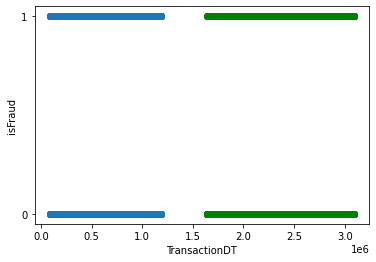

In [4]:
plt.scatter(train.TransactionDT, train.isFraud)
plt.scatter(test.TransactionDT, test.isFraud, c='g')
plt.yticks([0, 1])
plt.xlabel('TransactionDT')
plt.ylabel('isFraud');

In [5]:
train.shape, test.shape

((50001, 394), (75000, 394))

У нас достаточно данных, чтобы валидировать как Hold Out, так и K-Fold. Для начала можно взять Hold Out, а перед тестом пересчитать модель с кросс-валидацией.

#### Задание 1.2

Построить scatter-plot зависимости суммы транзакции от времени совершения транзакции. Построить графики для обучающей выборки и для тестовой выборки, для обучающей выборки - построить как для целевой переменной = 0, так и для переменной = 1. Сделать выводы.

Похоже, что столбец TransactionDT - секунды =)

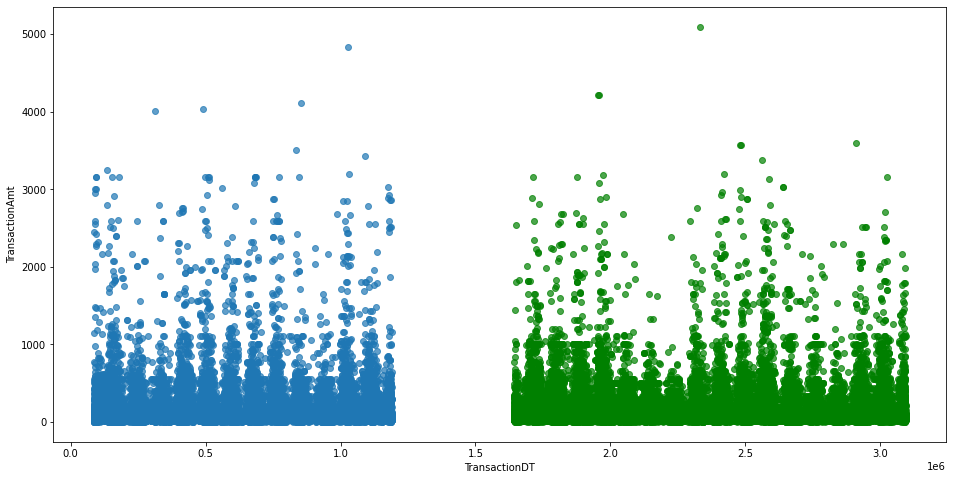

In [6]:
plt.figure(figsize=(16, 8))
plt.scatter(train.TransactionDT, train.TransactionAmt, alpha=0.7)
plt.scatter(test.TransactionDT, test.TransactionAmt, alpha=0.7, c='g')
plt.ylabel('TransactionAmt')
plt.xlabel('TransactionDT');

Возможно есть периодичность - зависимость суммы транзакции от времени дня. (**не забыть проверить**)

Срез TransactionAmt.mean по часам.

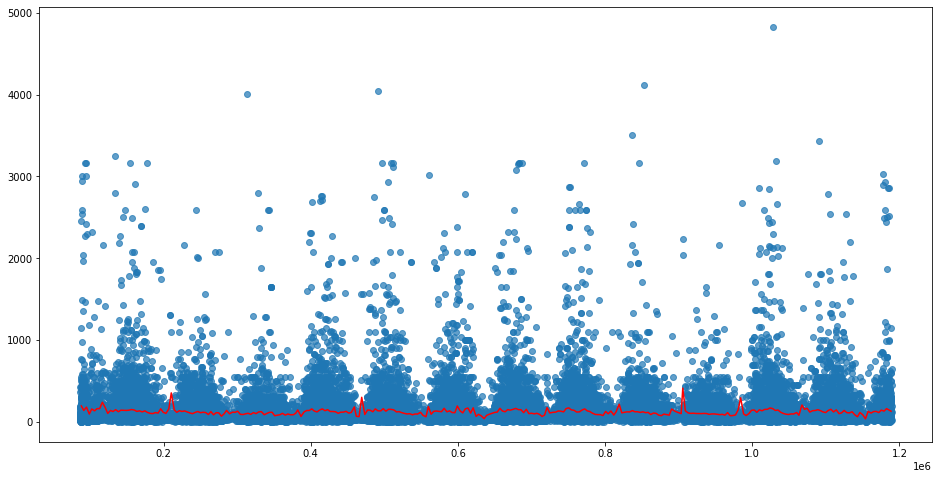

In [7]:
train_cnc = train[['TransactionDT', 'TransactionAmt']]
train_cnc['date'] = pd.to_datetime(train_cnc['TransactionDT'], unit='s') 
train_cnc = train_cnc.set_index('date')
train_cnc = train_cnc.resample('H').mean();

plt.figure(figsize=(16, 8))
plt.scatter(train.TransactionDT, train.TransactionAmt, alpha=0.7)
plt.plot(train_cnc.TransactionDT, train_cnc.TransactionAmt, c='r');

То же для test

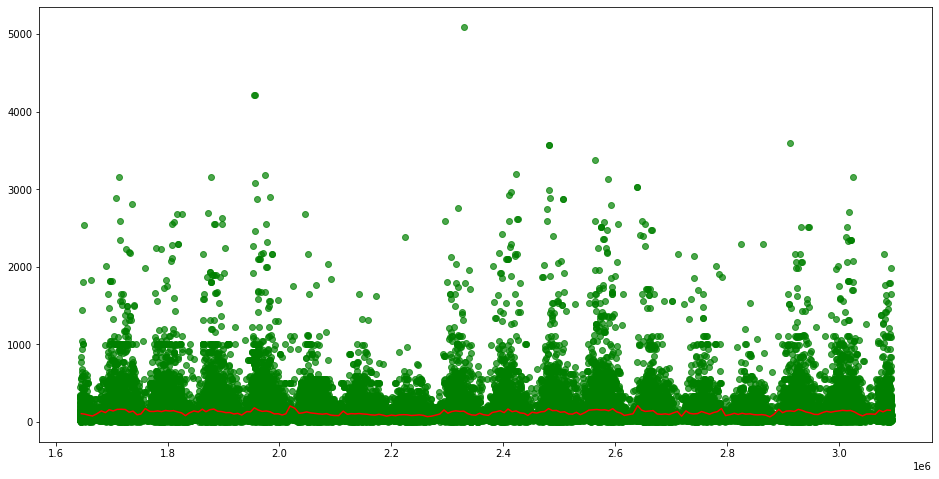

In [8]:
test_cnc = test[['TransactionDT', 'TransactionAmt']]
test_cnc['date'] = pd.to_datetime(test_cnc['TransactionDT'], unit='s') 
test_cnc = test_cnc.set_index('date')
test_cnc = test_cnc.resample('2H').mean();

plt.figure(figsize=(16, 8))
plt.scatter(test.TransactionDT, test.TransactionAmt, alpha=0.7, c='g')
plt.plot(test_cnc.TransactionDT, test_cnc.TransactionAmt, c='r');

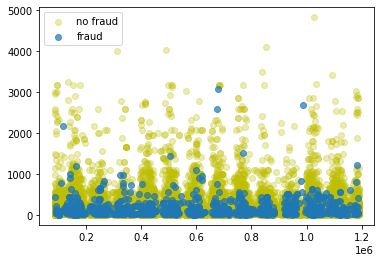

In [9]:
isFraud, noFraud = train[train.isFraud == 1], train[train.isFraud == 0]

plt.scatter(noFraud.TransactionDT, noFraud.TransactionAmt, c='y', alpha=0.3);
plt.scatter(isFraud.TransactionDT, isFraud.TransactionAmt, alpha=0.7);
plt.legend(['no fraud', 'fraud']);

In [10]:
isFraud.TransactionAmt.mean(), noFraud.TransactionAmt.mean()

(145.79397936624906, 127.63695393059781)

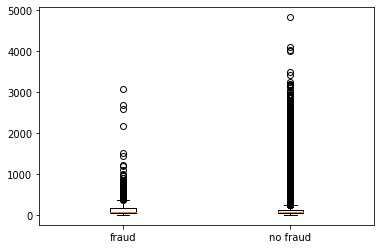

In [11]:
plt.boxplot([isFraud['TransactionAmt'], noFraud['TransactionAmt']]);
plt.xticks([1, 2], ['fraud', 'no fraud']);

#### Задание 1.3

Построить распределение признака TransactionAmt в логарифмическом масштабе, сделать выводы о близости распредления к нормальному распределению. Построить распределение признака в логарифмическому масштабе для обучающей выборк и для тестовой выборки, сделать выводы.

In [12]:
from scipy.stats import shapiro, normaltest

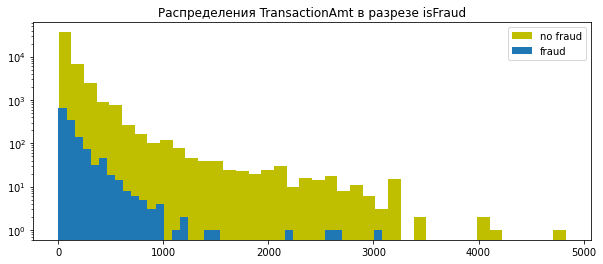

In [13]:
plt.figure(figsize=(10, 4))
plt.hist(noFraud['TransactionAmt'], bins=40, log=True, color='y')
plt.hist(isFraud['TransactionAmt'], bins=40, log=True)

plt.legend(['no fraud', 'fraud'])
plt.title('Распределения TransactionAmt в разрезе isFraud');

In [14]:
shapiro(train.TransactionAmt), shapiro(test.TransactionAmt)

(ShapiroResult(statistic=0.43240541219711304, pvalue=0.0),
 ShapiroResult(statistic=0.47631531953811646, pvalue=0.0))

распределение TransactionAmt не нормально

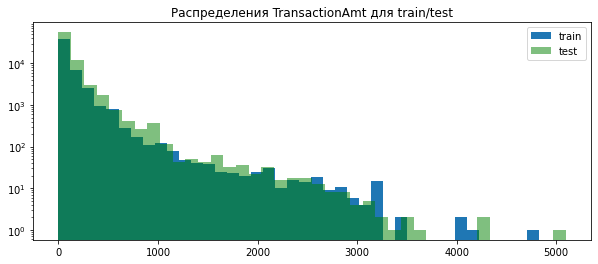

In [15]:
plt.figure(figsize=(10, 4))
plt.hist(train['TransactionAmt'], bins=40, log=True)
plt.hist(test['TransactionAmt'], bins=40, log=True, alpha=0.5, color='g')

plt.legend(['train', 'test'])
plt.title('Распределения TransactionAmt для train/test');

Распределения TransactionAmt для train/test достаточно близкие, но надо проверить. Т.к. распределение не Гауссовское и выборки связанные (**это надо еще доказать**), то применим тест Вилкоксона.

In [16]:
from scipy.stats import wilcoxon

т.к. выборки разных размеров, придется их рандомно нарезать и для каждой пары смотреть критерий (**так правильно сделать?**)

In [17]:
res = []
size = train.shape[0]

for x in range(10):
    a = [np.random.choice(train.TransactionAmt, replace=True) for i in range(size)]
    b = [np.random.choice(test.TransactionAmt, replace=True) for i in range(size)]
    
    res.append(wilcoxon(a, b))
    
res

[WilcoxonResult(statistic=584886184.5, pvalue=1.103393199846232e-06),
 WilcoxonResult(statistic=589487515.0, pvalue=0.0010709140512409538),
 WilcoxonResult(statistic=574530026.5, pvalue=1.2461935847791306e-16),
 WilcoxonResult(statistic=583520208.5, pvalue=1.1982399738931063e-06),
 WilcoxonResult(statistic=582247335.0, pvalue=1.71420901471182e-08),
 WilcoxonResult(statistic=589180181.0, pvalue=9.257470866300135e-05),
 WilcoxonResult(statistic=584055736.0, pvalue=6.477424575603982e-07),
 WilcoxonResult(statistic=580012671.5, pvalue=1.0293960857251858e-11),
 WilcoxonResult(statistic=585503692.0, pvalue=4.5880081869916645e-06),
 WilcoxonResult(statistic=580693309.0, pvalue=1.4559921111413573e-10)]

и что теперь с этим делать... =/

In [18]:
import scipy.stats as st

<AxesSubplot:title={'center':'Log Normal'}, xlabel='TransactionAmt'>

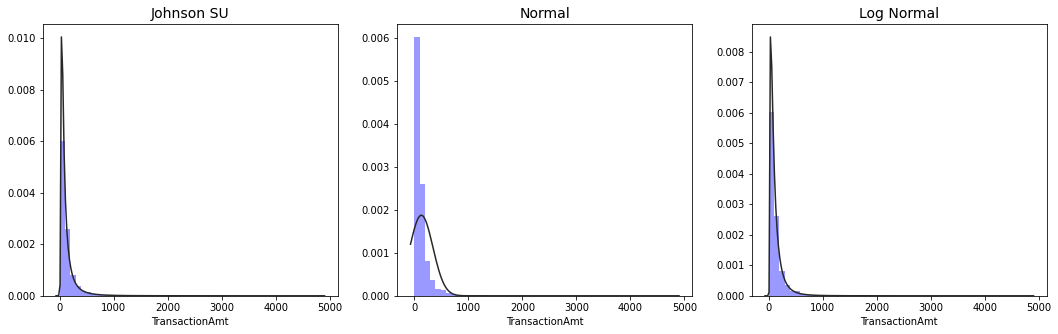

In [19]:
target = train.TransactionAmt
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

axes[0].set_title("Johnson SU", fontsize=14)
sns.distplot(target, kde=False, color="blue", fit=st.johnsonsu, ax=axes[0])

axes[1].set_title("Normal", fontsize=14)
sns.distplot(target, kde=False, color="blue", fit=st.norm, ax=axes[1])

axes[2].set_title("Log Normal", fontsize=14)
sns.distplot(target, kde=False, color="blue", fit=st.lognorm, ax=axes[2])

ничего не подходит

#### Задание 1.4  
Построить распределение признака целевой переменной в зависимости от значений категориальных признаков ProductCD, card4, card6. Сделать выводы.

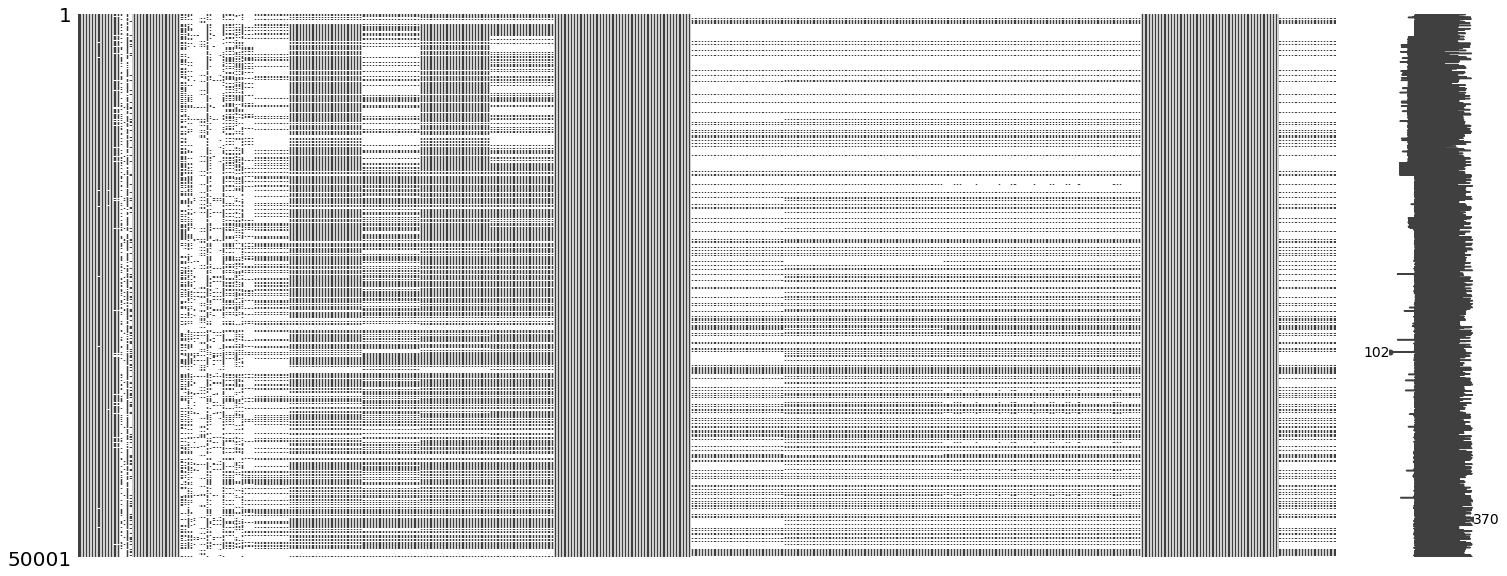

In [20]:
msno.matrix(train);

In [21]:
def plot_for(feat):
    frauds_vals = []
    nofrauds_vals = []

    labels = train[feat].unique()

    for label in labels:
        frauds_vals.append(isFraud[isFraud[feat]==label].TransactionAmt.to_list())
        nofrauds_vals.append(noFraud[noFraud[feat]==label].TransactionAmt.to_list())

    fig, axes = plt.subplots(2, 4, figsize=(15, 15))

    for num, label in enumerate(labels):
        d1 = frauds_vals[num]
        d2 = nofrauds_vals[num]

        p = axes[num//4, num%4]
        p.boxplot([d1, d2])
        p.set_title(label, fontsize=12)
        p.set_xticklabels(['fraud', 'no fraud'])

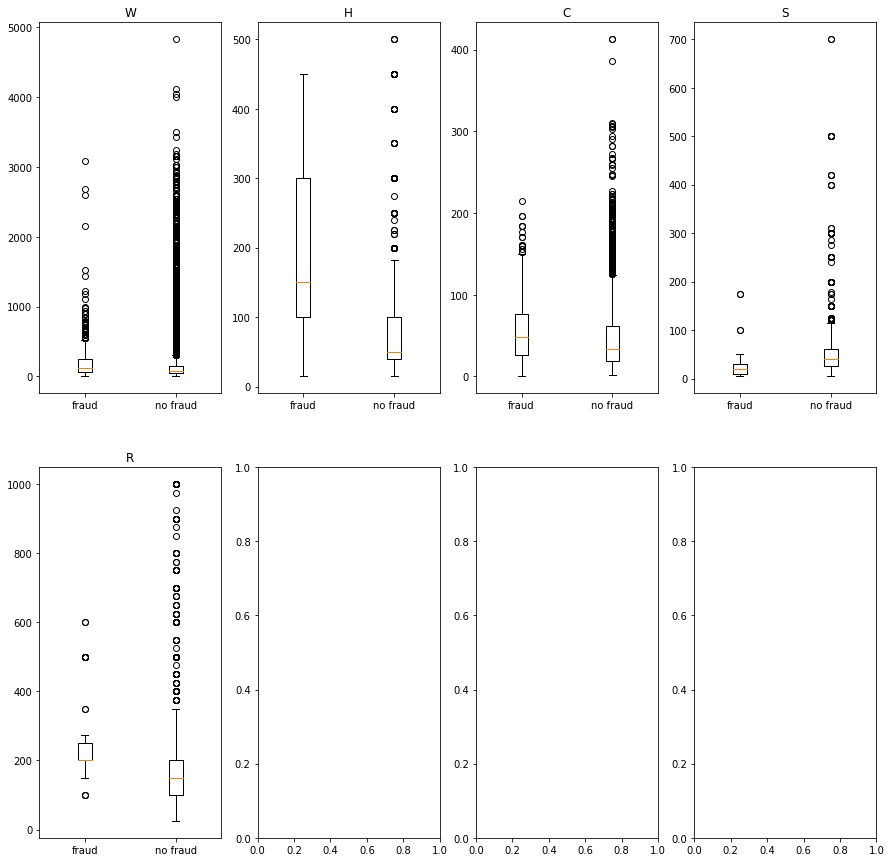

In [22]:
plot_for('ProductCD')

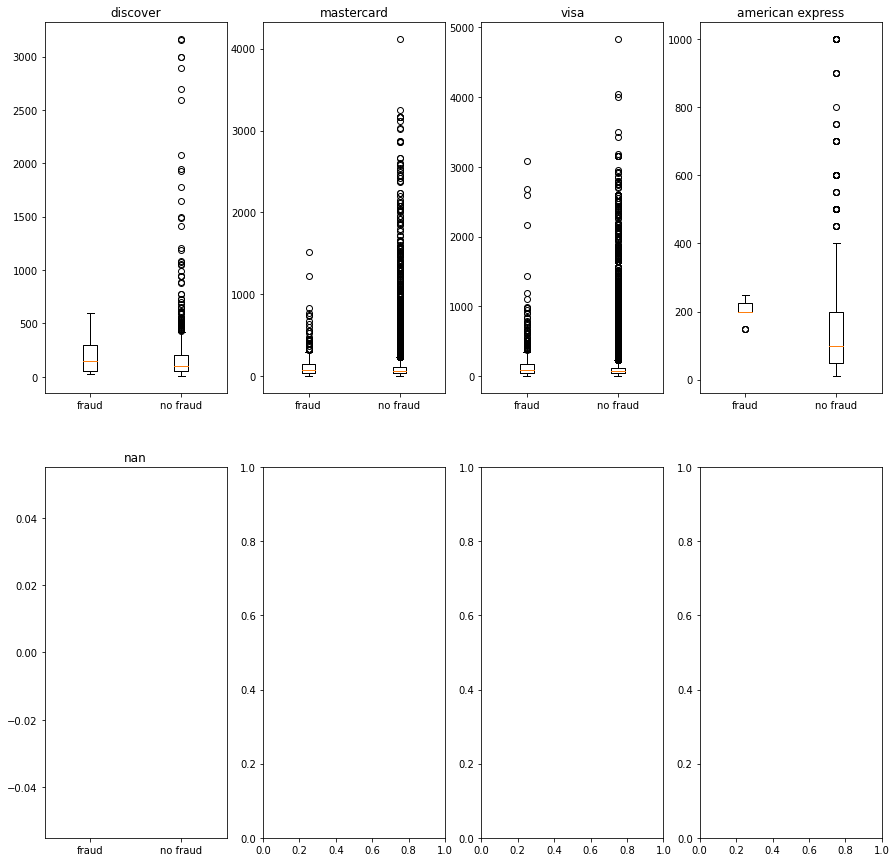

In [23]:
plot_for('card4')

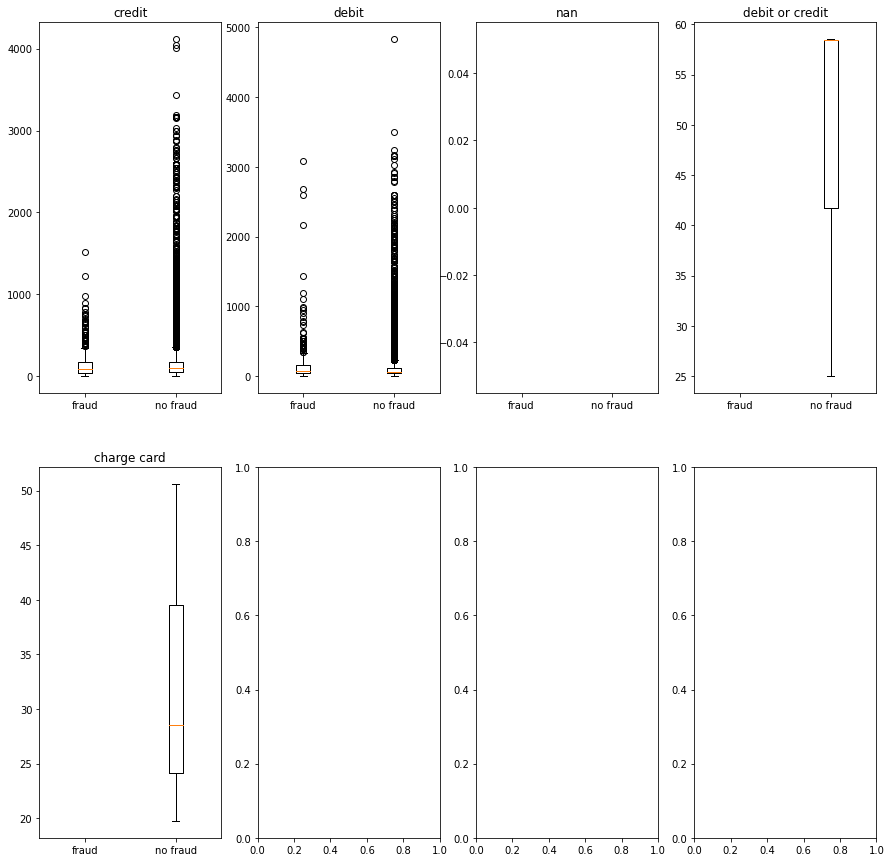

In [24]:
plot_for('card6')

Основное задание:
Даны выборки для обучения и для тестирования. Задание заключается в том, чтобы попробовать разные способы валидации, проанализировать плюсы / минусы каждой и сделать выводы о том, какой способ валидации наиболее устойчивый в данной задаче. Метрика качества для оценки прогнозов - ROC-AUC, название целевой переменной - IsFraud. Рекомендуется использовать модели градиетного бустинга, реализация любая.

**Задание 1:** сделать Hold-Out валидацию с разбиением, размер которого будет адеквтаным, по вашему мнению; разбиение проводить по id-транзакции (TransactionID), обучать модель градиетного бустинга любой реализации с подбором числа деревьев по early_stopping критерию до достижения сходимости. Оценить качество модели на тестовой выборке, оценить расхождение по сравнению с качеством на обучающей выборке и тестовой выборке.

**Задание 2:** сделать Hold-Out валидацию с разбиением на 3 выборки, разбиение проводить по id-транзакции (TransactionID), размер каждой выборки подобрать самостоятельно. Повторить процедуру из п.1.

**Задание 3:** построить доверительный интервал на данных из п.2 на основе бутстреп выборок, оценить качество модели на тестовом выборке относительно полученного доверительного интервала. Сделать выводы.

**Задание 4:** выполнить Adversarial Validation на основе данных из обучения / теста, подобрать объема из обучающей выборки, которые сильно похожи на объекты из тестовой выборки, и использовать их в качестве валидационного набора. Сделать выводы о полученных результатах.

**Задание 5:** сделать KFold / StratifiedKFold валидацию (на ваше усмотрение), оценить получаемые качество и разброс по метрике качества. Сделать выводы об устойчивости кросс-валидации, сходимости оценки на кросс-валидации и отложенном наборе данных;

**Задание 6** *(опциональное): сделать Hold-Out валидацию по времени (TransactionDT), повторить процедуры из п.1 / п.2 (на ваш выбор). Построить доверительный интервал, сравнить качество на тестовой выборке с полученным доверительным интервалом. Сделать выводы.

**Задание 7** ** (совсем опциональное): в данном наборе данных у нас есть ID-транзакции (TransactionID) и время транзакции (TransactionDT), но отсутствует ID-клиента, который совершал транзакции. Кажется, что в этой задаче валидация по клиенту работала бы хорошо. Предложить критерий, по которому можно выделить клиентов и сделать п.5, используя созданное определение клиента, используя валидацию по клиенту (GroupKFold).

#### Задание 1

Сделать Hold-Out валидацию с разбиением, размер которого будет адеквтаным, по вашему мнению; разбиение проводить по id-транзакции (TransactionID), обучать модель градиетного бустинга любой реализации с подбором числа деревьев по early_stopping критерию до достижения сходимости. Оценить качество модели на тестовой выборке, оценить расхождение по сравнению с качеством на обучающей выборке и тестовой выборке.

In [25]:
train.shape, test.shape

((50001, 394), (75000, 394))

In [26]:
len(set(train.TransactionID)), len(set(test.TransactionID)), len(set(train.TransactionID) & set(test.TransactionID))

(50001, 75000, 0)

Все TransactionID уникальны. Нет пересечений между трейн и тест.

In [27]:
numerical_features = train.select_dtypes(include=[np.number])
print(f"count of numeric_features {numerical_features.shape[1]}")

count of numeric_features 380


In [28]:
x_train, x_test = train_test_split(
    numerical_features.drop(["TransactionID", "isFraud"], axis=1), 
    train_size=0.75, shuffle=True, random_state=42)

In [29]:
y_train, y_test = train_test_split(
    train.isFraud, 
    train_size=0.75, shuffle=True, random_state=42)

In [30]:
x_train.shape, x_test.shape

((37500, 378), (12501, 378))

In [31]:
model_2 = xgb.XGBRegressor(random_state=42)
model_2.fit(x_train, y_train, early_stopping_rounds=50, eval_metric="auc", eval_set=[(x_train, y_train), (x_test, y_test)])

[0]	validation_0-auc:0.79625	validation_1-auc:0.76036
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 50 rounds.
[1]	validation_0-auc:0.81656	validation_1-auc:0.76386
[2]	validation_0-auc:0.83275	validation_1-auc:0.78972
[3]	validation_0-auc:0.83607	validation_1-auc:0.78714
[4]	validation_0-auc:0.84957	validation_1-auc:0.80166
[5]	validation_0-auc:0.87180	validation_1-auc:0.82565
[6]	validation_0-auc:0.88628	validation_1-auc:0.83676
[7]	validation_0-auc:0.88789	validation_1-auc:0.83667
[8]	validation_0-auc:0.88894	validation_1-auc:0.83666
[9]	validation_0-auc:0.89786	validation_1-auc:0.83914
[10]	validation_0-auc:0.90456	validation_1-auc:0.84236
[11]	validation_0-auc:0.90876	validation_1-auc:0.84057
[12]	validation_0-auc:0.91260	validation_1-auc:0.84745
[13]	validation_0-auc:0.91387	validation_1-auc:0.84423
[14]	validation_0-auc:0.91650	validation_1-auc:0.84511
[15]	validation_0-auc:0.9172

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=100, n_jobs=0, num_parallel_tree=1, random_state=42,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

In [33]:
train_score = roc_auc_score(y_train, model_2.predict(x_train))
test_score = roc_auc_score(y_test, model_2.predict(x_test))

print(f"Train-score: {round(train_score, 3)}, Test-score: {round(test_score, 3)}")

Train-score: 0.974, Test-score: 0.888


Данных достаточно, разница в 4% не большая, думаю не переобученно и точно не недообучено. Возможно чистка данных нам поможет.

#### Задание 2 
Сделать Hold-Out валидацию с разбиением на 3 выборки, разбиение проводить по id-транзакции (TransactionID), размер каждой выборки подобрать самостоятельно. Повторить процедуру из п.1.

In [34]:
x_train, x_valid = train_test_split(
    numerical_features.drop(["TransactionID", "isFraud"], axis=1), 
    train_size=0.7, shuffle=True, random_state=42,
)
y_train, y_valid = train_test_split(
    train.isFraud, 
    train_size=0.7, shuffle=True, random_state=42,
)

x_valid, x_test = train_test_split(
    x_valid, train_size=0.7, shuffle=True, random_state=27
)
y_valid, y_test = train_test_split(
    y_valid, train_size=0.7, shuffle=True, random_state=27
)

In [44]:
model_3 = xgb.XGBRegressor(random_state=42)
model_3.fit(x_train, y_train, early_stopping_rounds=50, eval_metric="auc", eval_set=[(x_train, y_train), (x_valid, y_valid)])

[0]	validation_0-auc:0.79480	validation_1-auc:0.74551
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 50 rounds.
[1]	validation_0-auc:0.81991	validation_1-auc:0.76675
[2]	validation_0-auc:0.83704	validation_1-auc:0.79378
[3]	validation_0-auc:0.83888	validation_1-auc:0.79495
[4]	validation_0-auc:0.86872	validation_1-auc:0.82590
[5]	validation_0-auc:0.87538	validation_1-auc:0.82667
[6]	validation_0-auc:0.87967	validation_1-auc:0.83150
[7]	validation_0-auc:0.89446	validation_1-auc:0.84479
[8]	validation_0-auc:0.89735	validation_1-auc:0.84888
[9]	validation_0-auc:0.90014	validation_1-auc:0.84661
[10]	validation_0-auc:0.90647	validation_1-auc:0.85691
[11]	validation_0-auc:0.90761	validation_1-auc:0.85701
[12]	validation_0-auc:0.90881	validation_1-auc:0.85787
[13]	validation_0-auc:0.91110	validation_1-auc:0.86132
[14]	validation_0-auc:0.91541	validation_1-auc:0.85199
[15]	validation_0-auc:0.9200

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=100, n_jobs=0, num_parallel_tree=1, random_state=42,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

In [45]:
train_score = roc_auc_score(y_train, model_3.predict(x_train))
valid_score = roc_auc_score(y_valid, model_3.predict(x_valid))
test_score = roc_auc_score(y_test, model_3.predict(x_test))

print(f"Train-score: {round(train_score, 3)}, Valid-score: {round(valid_score, 3)}, Test-score: {round(test_score, 3)}")

Train-score: 0.964, Valid-score: 0.891, Test-score: 0.878


Разница между валид и тест скором минимальна. Значит модель не переобучилась под валид. Возможно переобучилась под трейн.

#### Задание 3 

Построить доверительный интервал на данных из п.2 на основе бутстреп выборок, оценить качество модели на тестовом выборке относительно полученного доверительного интервала. Сделать выводы.

In [37]:
def create_bootstrap_samples(data: np.array, n_samples: int = 1000) -> np.array:
    """
    Создание бутстреп-выборок.

    Parameters
    ----------
    data: np.array
        Исходная выборка, которая будет использоваться для
        создания бутстреп выборок.

    n_samples: int, optional, default = 1000
        Количество создаваемых бутстреп выборок.
        Опциональный параметр, по умолчанию, равен 1000.

    Returns
    -------
    bootstrap_idx: np.array
        Матрица индексов, для создания бутстреп выборок.

    """
    bootstrap_idx = np.random.randint(
        low=0, high=len(data), size=(n_samples, len(data))
    )
    return bootstrap_idx


def create_bootstrap_metrics(y_true: np.array,
                             y_pred: np.array,
                             metric: callable,
                             n_samlpes: int = 1000) -> List[float]:
    """
    Вычисление бутстреп оценок.

    Parameters
    ----------
    y_true: np.array
        Вектор целевой переменной.

    y_pred: np.array
        Вектор прогнозов.

    metric: callable
        Функция для вычисления метрики.
        Функция должна принимать 2 аргумента: y_true, y_pred.

    n_samples: int, optional, default = 1000
        Количество создаваемых бутстреп выборок.
        Опциональный параметр, по умолчанию, равен 1000.

    Returns
    -------
    bootstrap_metrics: List[float]
        Список со значениями метрики качества на каждой бустреп выборке.

    """
    scores = []

    if isinstance(y_true, pd.Series):
        y_true = y_true.values

    bootstrap_idx = create_bootstrap_samples(y_true)
    for idx in bootstrap_idx:
        y_true_bootstrap = y_true[idx]
        y_pred_bootstrap = y_pred[idx]

        score = metric(y_true_bootstrap, y_pred_bootstrap)
        scores.append(score)

    return scores


def calculate_confidence_interval(scores: list, conf_interval: float = 0.95) -> Tuple[float]:
    """
    Вычисление доверительного интервала.

    Parameters
    ----------
    scores: List[float / int]
        Список с оценками изучаемой величины.

    conf_interval: float, optional, default = 0.95
        Уровень доверия для построения интервала.
        Опциональный параметр, по умолчанию, равен 0.95.

    Returns
    -------
    conf_interval: Tuple[float]
        Кортеж с границами доверительного интервала.

    """
    left_bound = np.percentile(
        scores, ((1 - conf_interval) / 2) * 100
    )
    right_bound = np.percentile(
        scores, (conf_interval + ((1 - conf_interval) / 2)) * 100
    )

    return left_bound, right_bound

In [46]:
np.random.seed(42)
scores = create_bootstrap_metrics(y_valid, model_3.predict(x_valid), roc_auc_score)

calculate_confidence_interval(scores)

(0.8674716553583496, 0.9130529415410399)

Разница в 4 пункта - довольно хороший результат. И т.к. тест скор 0.878 лежит внутри - валидация хорошая.

#### Задание 4 
Выполнить Adversarial Validation на основе данных из обучения / теста, подобрать объема из обучающей выборки, которые сильно похожи на объекты из тестовой выборки, и использовать их в качестве валидационного набора. Сделать выводы о полученных результатах.